In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm

sys.path.insert(0, "../")

%load_ext autoreload
%autoreload 2

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import src

In [4]:
from src.functional.smpl import get_smpl_model

In [16]:
batch_size = 100
device = "cuda:0"
smpl_model = get_smpl_model("h36m", batch_size=batch_size, device=device)
smpl_model_faces = torch.tensor(smpl_model.faces.astype(int).copy())

In [35]:
torch.manual_seed(0)
smpl_pose = torch.zeros(batch_size, 69).to(device)
global_orient = torch.zeros(batch_size,3).to(device)
global_orient[:,0] = torch.pi
pred_out = smpl_model(body_pose=smpl_pose, global_orient=global_orient, pose2rot=True)
verts = pred_out.vertices

In [52]:
from src.utils.vis_utils import render_mesh_onto_image

def render_verts_only(verts, faces, device, img_size=512):
    verts_mean = verts.copy().mean(axis=0, keepdims=True)
    verts -= verts_mean
    scale = 0.8
    verts *= scale
    verts = (verts + 1) / 2 * img_size
    img = (255 * np.ones((img_size, img_size, 3))).astype("uint8")
    blend = render_mesh_onto_image(img, verts, faces, device)
    return blend

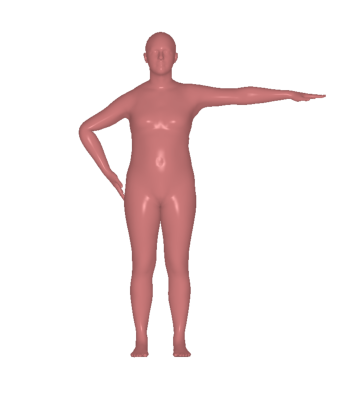

In [152]:
torch.manual_seed(0)


smpl_pose = torch.zeros(batch_size, 69).to(device)

# ### to get 0 body - do nothing

# ### to get penetrated body
# idx = 13 # shoulder
# smpl_pose[:, idx*3:idx*3+3] = torch.tensor([0.,0.,1.]) * torch.pi / 4 * 0.8
# idx = 18 # elbow
# smpl_pose[:, idx*3:idx*3+3] = torch.tensor([0.,0.,1.]) * torch.pi / 4 * 2.5

### to get fixed body
idx = 13 # shoulder
smpl_pose[:, idx*3:idx*3+3] = torch.tensor([0.,0.,1.]) * torch.pi / 4 * 0.65
idx = 18 # elbow
smpl_pose[:, idx*3:idx*3+3] = torch.tensor([0.,0.,1.]) * torch.pi / 4 * 2.

global_orient = torch.zeros(batch_size,3).to(device)
global_orient[:,0] = torch.pi
# global_orient[:,2] = torch.pi
pred_out = smpl_model(body_pose=smpl_pose, global_orient=global_orient, pose2rot=True)
verts = pred_out.vertices

img = render_verts_only(verts.detach().cpu().numpy()[0], smpl_model_faces, device, img_size=1024)
fig, ax = plt.subplots(1,1,  figsize=(7,7))
ax.set_axis_off();
ax.imshow(img[200:,150:-150]);

